<a href="https://colab.research.google.com/github/liuxx479/Outlier/blob/master/notebooks/ResNet_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Short introduction to the Outlier package

In [1]:
%pylab inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
!pip install --quiet git+https://github.com/liuxx479/Outlier.git
from outlier.datasets import gaussian_convergence

In [3]:
%tensorflow_version 2.x
%pylab inline
import tensorflow_datasets as tfds
from outlier.datasets import gaussian_convergence

Populating the interactive namespace from numpy and matplotlib


In [4]:
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/My Drive'
data_path = os.path.join(root,'tensorflow_datasets/')
model_path= os.path.join(root,'models/Keras')

if not os.path.isdir(model_path):
    os.makedirs(model_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
S8_gen= lambda params: sqrt(params.T[0]/0.3)*params.T[1]

In [0]:
VERSION = tfds.core.Version('0.1.0')
dataset, info = tfds.load(name="gaussian_convergence", download=0, split="train", data_dir=data_path, with_info=True)

In [0]:
## Implementing a simple resnet model
def redefine(data):
    x    = data['map'] 
    x    = tf.expand_dims(x,-1)
    y    = data['params']
    return x, y

def downsample(x,y):
    x    = tf.image.resize(x,[128,128])
    return x, y
  
def augmentation(x, y):
  x = tf.image.random_flip_left_right(x)
  x = tf.image.random_flip_up_down(x)
  x = tf.image.rot90(x, k=randint(4)) 
  # x = x + 0.02*tf.random.normal(shape=(128,128,1))
  return x, y

In [0]:
DATASET_SIZE = 20000
BATCH_SIZE = 32*4

train_size = int(0.8 * DATASET_SIZE)
test_size = int(0.2 * DATASET_SIZE)

full_dataset = dataset.map(redefine).map(downsample)

train_dataset= full_dataset.take(train_size).repeat().map(augmentation).shuffle(buffer_size=2000).batch(BATCH_SIZE)
test_dataset = full_dataset.skip(train_size).take(test_size).map(augmentation).batch(BATCH_SIZE)

### Let's define the neural network

In [0]:
inputs = tf.keras.Input(shape=(128, 128, 1))
resnet = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False,
                                                    weights=None,
                                                    input_shape=[128,128,1],
                                                    pooling='avg',
              # classifier_activation=tf.keras.layers.LeakyReLU(alpha=0.3)
              )
net = resnet(inputs)
outputs = tf.keras.layers.Dense(2)(net)

In [10]:
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
resnet50v2 (Model)           (None, 2048)              23558528  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,562,626
Trainable params: 23,517,186
Non-trainable params: 45,440
_________________________________________________________________


In [0]:
checkpoint_file = os.path.join(model_path+'/weights.{epoch:02d}-{val_loss:.3f}.hdf5')
ckpt_callback   = keras.callbacks.ModelCheckpoint(filepath=checkpoint_file, monitor='val_loss')
callbacks     = [ckpt_callback]
hists = []

In [12]:
def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    try:
        return max(paths, key=os.path.getctime)
    except:
        return None

latest_file=newest(model_path)

print(latest_file)

/content/drive/My Drive/models/Keras/save


### Training

In [0]:
latest_file=None #model_path+'/weights.50-0.020.hdf5'
if latest_file is None:
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),loss='mse')    
  # res_net_model.compile(optimizer=keras.optimizers.Adam(),loss=loss_L2,metrics=['mse','mse'])  
else:
  print(latest_file)
  model = keras.models.load_model(latest_file)

In [16]:
history = model.fit(train_dataset, epochs=50, batch_size=BATCH_SIZE,
                    verbose=1, 
                    steps_per_epoch=int(0.8*20000/BATCH_SIZE)-1,
                    validation_data=test_dataset,validation_steps=2,
                    callbacks=callbacks
                    )
hists.append(history)

Epoch 1/50
124/124 [==============================] - 39s 318ms/step - loss: 0.1126 - val_loss: 0.1781
Epoch 2/50
124/124 [==============================] - 39s 313ms/step - loss: 0.0277 - val_loss: 0.0600
Epoch 3/50
124/124 [==============================] - 39s 314ms/step - loss: 0.0242 - val_loss: 0.0177
Epoch 4/50
124/124 [==============================] - 39s 314ms/step - loss: 0.0227 - val_loss: 0.0449
Epoch 5/50
124/124 [==============================] - 39s 316ms/step - loss: 0.0207 - val_loss: 0.0191
Epoch 6/50
124/124 [==============================] - 39s 311ms/step - loss: 0.0190 - val_loss: 0.0290
Epoch 7/50
124/124 [==============================] - 39s 318ms/step - loss: 0.0181 - val_loss: 0.0193
Epoch 8/50
124/124 [==============================] - 39s 315ms/step - loss: 0.0166 - val_loss: 0.0224
Epoch 9/50
124/124 [==============================] - 39s 318ms/step - loss: 0.0158 - val_loss: 0.0178
Epoch 10/50
124/124 [==============================] - 40s 319ms/step - l

(128, 128, 128, 1) (128, 2)


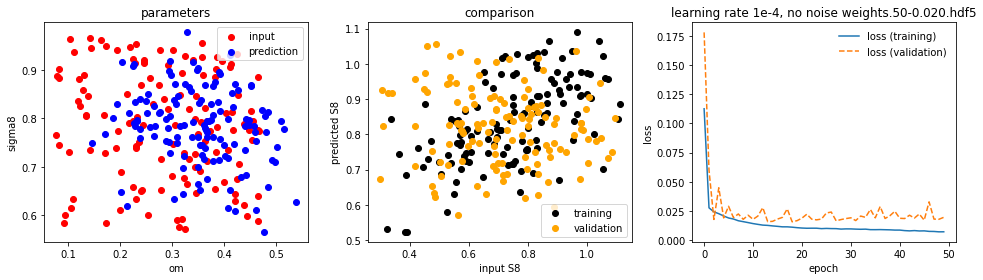

In [17]:
truth = next(train_dataset.as_numpy_iterator()) 
print (truth[0].shape, truth[1].shape)
predictions = model.predict(x=truth[0])

truth_valid = next(test_dataset.as_numpy_iterator())
predictions_validation = model.predict(x=truth_valid[0])
params_valid = truth_valid[1]

params_pred = predictions
params_input = truth[1]
true_s8=S8_gen(params_input)
pred_s8=S8_gen(np.array(params_pred))

true_s8_valid=S8_gen(params_valid)
pred_s8_valid=S8_gen(np.array(predictions_validation))

losses_train=history.history['loss']
losses_val=history.history['val_loss']
epocharr=history.epoch

figure(figsize=(14,4))
subplot(1,3,1)
scatter(params_input.T[0], params_input.T[1],color='r', label='input')
scatter(params_pred.T[0], params_pred.T[1],color='b', label='prediction')
title('parameters')
xlabel('om')
ylabel('sigma8')
legend(fontsize=10, frameon=1)
subplot(1,3,2)
scatter(true_s8, pred_s8, color='k',label='training')
scatter(true_s8_valid, pred_s8_valid, color='orange',label='validation')
legend(fontsize=10, frameon=1)
xlabel('input S8')
ylabel('predicted S8')
#ylim(0,1)
title('comparison')
subplot(1,3,3)
plot(epocharr, losses_train,'-',label='loss (training)')
plot(epocharr, losses_val, '--',label='loss (validation)')
legend(fontsize=10, frameon=0)
xlabel('epoch')
ylabel('loss')
title('learning rate 1e-4, no noise weights.50-0.020.hdf5')
plt.tight_layout()